# Sudoku miniproject

Below you will find the most elegant solution of sudoku solver coded by Peter Norvig. It's a good notation and implementation of two (simple) techniques that are enough to solve sudoku in a reasonable time.

You can find the original post here: http://norvig.com/sudoku.html

The best website about sudoku: http://www.sudokudragon.com/sudokutheory.htm

### Sudoku Notation and Preliminary Notions

First we have to agree on some notation. A Sudoku puzzle is a grid of 81 squares; the majority of enthusiasts label the columns 1-9, the rows A-I, and call a collection of nine squares (column, row, or box) a unit and the squares that share a unit the peers. A puzzle leaves some squares blank and fills others with digits, and the whole idea is:
A puzzle is solved if the squares in each unit are filled with a permutation of the digits 1 to 9.
That is, no digit can appear twice in a unit, and every digit must appear once. This implies that each square must have a different value from any of its peers. Here are the names of the squares, a typical puzzle, and the solution to the puzzle:

```
 A1 A2 A3| A4 A5 A6| A7 A8 A9    4 . . |. . . |8 . 5     4 1 7 |3 6 9 |8 2 5 
 B1 B2 B3| B4 B5 B6| B7 B8 B9    . 3 . |. . . |. . .     6 3 2 |1 5 8 |9 4 7
 C1 C2 C3| C4 C5 C6| C7 C8 C9    . . . |7 . . |. . .     9 5 8 |7 2 4 |3 1 6 
---------+---------+---------    ------+------+------    ------+------+------
 D1 D2 D3| D4 D5 D6| D7 D8 D9    . 2 . |. . . |. 6 .     8 2 5 |4 3 7 |1 6 9 
 E1 E2 E3| E4 E5 E6| E7 E8 E9    . . . |. 8 . |4 . .     7 9 1 |5 8 6 |4 3 2 
 F1 F2 F3| F4 F5 F6| F7 F8 F9    . . . |. 1 . |. . .     3 4 6 |9 1 2 |7 5 8 
---------+---------+---------    ------+------+------    ------+------+------
 G1 G2 G3| G4 G5 G6| G7 G8 G9    . . . |6 . 3 |. 7 .     2 8 9 |6 4 3 |5 7 1 
 H1 H2 H3| H4 H5 H6| H7 H8 H9    5 . . |2 . . |. . .     5 7 3 |2 9 1 |6 8 4 
 I1 I2 I3| I4 I5 I6| I7 I8 I9    1 . 4 |. . . |. . .     1 6 4 |8 7 5 |2 9 3 
```

Every square has exactly 3 units and 20 peers. For example, here are the units and peers for the square C2:

```
    A2   |         |                    |         |            A1 A2 A3|         |         
    B2   |         |                    |         |            B1 B2 B3|         |         
    C2   |         |            C1 C2 C3| C4 C5 C6| C7 C8 C9   C1 C2 C3|         |         
---------+---------+---------  ---------+---------+---------  ---------+---------+---------
    D2   |         |                    |         |                    |         |         
    E2   |         |                    |         |                    |         |         
    F2   |         |                    |         |                    |         |         
---------+---------+---------  ---------+---------+---------  ---------+---------+---------
    G2   |         |                    |         |                    |         |         
    H2   |         |                    |         |                    |         |         
    I2   |         |                    |         |                    |         |    
```

In [1]:
#notation

def cross(A, B):
    "Cross product of elements in A and elements in B."
    return [a+b for a in A for b in B]

digits   = '123456789'
rows     = 'ABCDEFGHI'
cols     = digits
squares  = cross(rows, cols)
unitlist = ([cross(rows, c) for c in cols] +
            [cross(r, cols) for r in rows] +
            [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')])
units = dict((s, [u for u in unitlist if s in u]) 
             for s in squares)
peers = dict((s, set(sum(units[s],[]))-set([s]))
             for s in squares)

print(units['A1'])

[['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9'], ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']]


### Sudoku grid
Now that we have squares, units, and peers, the next step is to define the Sudoku playing grid. Actually we need two representations: First, a textual format used to specify the initial state of a puzzle; we will reserve the name grid for this. Second, an internal representation of any state of a puzzle, partially solved or complete; this we will call a values collection because it will give all the remaining possible values for each square. For the textual format (grid) we'll allow a string of characters with 1-9 indicating a digit, and a 0 or period specifying an empty square. All other characters are ignored (including spaces, newlines, dashes, and bars). So each of the following three grid strings represent the same puzzle:



In [2]:
# parser
def grid_values(grid):
    "Convert grid into a dict of {square: char} with '0' or '.' for empties."
    chars = [c for c in grid if c in digits or c in '0.']
    assert len(chars) == 81
    return dict(zip(squares, chars))

def display(values):
    "Display these values as a 2-D grid."
    width = 1+max(len(values[s]) for s in squares)
    line = '+'.join(['-'*(width*3)]*3)
    for r in rows:
        print(''.join(values[r+c].center(width)+('|' if c in '36' else '') for c in cols))
        if r in 'CF': print(line)
    print()

# sample sudoku
grid1 = '003020600900305001001806400008102900700000008006708200002609500800203009005010300'
grid2 = "4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......"
display(grid_values(grid2))

4 . . |. . . |8 . 5 
. 3 . |. . . |. . . 
. . . |7 . . |. . . 
------+------+------
. 2 . |. . . |. 6 . 
. . . |. 8 . |4 . . 
. . . |. 1 . |. . . 
------+------+------
. . . |6 . 3 |. 7 . 
5 . . |2 . . |. . . 
1 . 4 |. . . |. . . 



### Parser
Now for values. One might think that a 9 x 9 array would be the obvious data structure. But squares have names like 'A1', not (0,0). Therefore, values will be a dict with squares as keys. The value of each key will be the possible digits for that square: a single digit if it was given as part of the puzzle definition or if we have figured out what it must be, and a collection of several digits if we are still uncertain. This collection of digits could be represented by a Python set or list, but I chose instead to use a string of digits (we'll see why later). So a grid where A1 is 7 and C7 is empty would be represented as {'A1': '7', 'C7': '123456789', ...}.

In [3]:
def parse_grid(grid):
    """Convert grid to a dict of possible values, {square: digits}, or
    return False if a contradiction is detected."""
    ## To start, every square can be any digit; then assign values from the grid.
    values = dict((s, digits) for s in squares)
    for s,d in grid_values(grid).items():
        if d in digits and not assign(values, s, d):
            return False ## (Fail if we can't assign d to square s.)
    return values

grid2 = "4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......"
sudoku_values = (grid_values(grid2))
                 
print(sudoku_values)

{'A1': '4', 'A2': '.', 'A3': '.', 'A4': '.', 'A5': '.', 'A6': '.', 'A7': '8', 'A8': '.', 'A9': '5', 'B1': '.', 'B2': '3', 'B3': '.', 'B4': '.', 'B5': '.', 'B6': '.', 'B7': '.', 'B8': '.', 'B9': '.', 'C1': '.', 'C2': '.', 'C3': '.', 'C4': '7', 'C5': '.', 'C6': '.', 'C7': '.', 'C8': '.', 'C9': '.', 'D1': '.', 'D2': '2', 'D3': '.', 'D4': '.', 'D5': '.', 'D6': '.', 'D7': '.', 'D8': '6', 'D9': '.', 'E1': '.', 'E2': '.', 'E3': '.', 'E4': '.', 'E5': '8', 'E6': '.', 'E7': '4', 'E8': '.', 'E9': '.', 'F1': '.', 'F2': '.', 'F3': '.', 'F4': '.', 'F5': '1', 'F6': '.', 'F7': '.', 'F8': '.', 'F9': '.', 'G1': '.', 'G2': '.', 'G3': '.', 'G4': '6', 'G5': '.', 'G6': '3', 'G7': '.', 'G8': '7', 'G9': '.', 'H1': '5', 'H2': '.', 'H3': '.', 'H4': '2', 'H5': '.', 'H6': '.', 'H7': '.', 'H8': '.', 'H9': '.', 'I1': '1', 'I2': '.', 'I3': '4', 'I4': '.', 'I5': '.', 'I6': '.', 'I7': '.', 'I8': '.', 'I9': '.'}


# Constraint Propagation - original code
The function parse_grid calls assign(values, s, d). We could implement this as values[s] = d, but we can do more than just that. Those with experience solving Sudoku puzzles know that there are two important strategies that we can use to make progress towards filling in all the squares:

(1) If a square has only one possible value, then eliminate that value from the square's peers. 

(2) If a unit has only one possible place for a value, then put the value there.

As an example of strategy (1) if we assign 7 to A1, yielding {'A1': '7', 'A2':'123456789', ...}, we see that A1 has only one value, and thus the 7 can be removed from its peer A2 (and all other peers), giving us {'A1': '7', 'A2': '12345689', ...}. As an example of strategy (2), if it turns out that none of A3 through A9 has a 3 as a possible value, then the 3 must belong in A2, and we can update to {'A1': '7', 'A2':'3', ...}. These updates to A2 may in turn cause further updates to its peers, and the peers of those peers, and so on. This process is called constraint propagation.

The function assign(values, s, d) will return the updated values (including the updates from constraint propagation), but if there is a contradiction--if the assignment cannot be made consistently--then assign returns False. For example, if a grid starts with the digits '77...' then when we try to assign the 7 to A2, assign would notice that 7 is not a possibility for A2, because it was eliminated by the peer, A1.

It turns out that the fundamental operation is not assigning a value, but rather eliminating one of the possible values for a square, which we implement with eliminate(values, s, d). Once we have eliminate, then assign(values, s, d) can be defined as "eliminate all the values from s except d".

In [4]:
from copy import deepcopy

def assign(values, s, d):
    """Eliminate all the other values (except d) from values[s] and propagate.
    Return values, except return False if a contradiction is detected."""
    other_values = values[s].replace(d, '')
    if all(eliminate_value(values, s, d2) for d2 in other_values):
        return values
    else:
        return False

def eliminate_value(values, s, d):
    """Eliminate d from values[s]; propagate when values or places <= 2.
    Return values, except return False if a contradiction is detected."""
    if d not in values[s]:
        return values ## Already eliminated
    values[s] = values[s].replace(d,'')
    ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
    if len(values[s]) == 0:
        return False ## Contradiction: removed last value
    elif len(values[s]) == 1:
        d2 = values[s]
        if not all(eliminate_value(values, s2, d2) for s2 in peers[s]):
            return False
    ## (2) If a unit u is reduced to only one place for a value d, then put it there.
    for u in units[s]:
        dplaces = [s for s in u if d in values[s]]
        if len(dplaces) == 0:
            return False ## Contradiction: no place for this value
        elif len(dplaces) == 1:
            # d can only be in one place in unit; assign it there
            if not assign(values, dplaces[0], d):
                return False
    return values

### Test run

In [5]:
grid2 = "4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......"
sudoku_values = (parse_grid(grid1))
display(sudoku_values)


4 8 3 |9 2 1 |6 5 7 
9 6 7 |3 4 5 |8 2 1 
2 5 1 |8 7 6 |4 9 3 
------+------+------
5 4 8 |1 3 2 |9 7 6 
7 2 9 |5 6 4 |1 3 8 
1 3 6 |7 9 8 |2 4 5 
------+------+------
3 7 2 |6 8 9 |5 1 4 
8 1 4 |2 5 3 |7 6 9 
6 9 5 |4 1 7 |3 8 2 



# Constraint Propagation - code refactoring

Try to decompose* eliminate function into smaller one.
* Decomposition is a process by which you can break down one complex function into multiple smaller functions. By doing this, you can solve for functions in shorter, easier-to-understand pieces.

In [6]:
# todo

def eliminate(values):
    """
    Iterate through all squares and every time 
       if there is a square with one value, 
       then eliminate this value from the peers

    input: sudoku in dictionary form
    output: resulting sudoku in dictionary form
    """
    for key in values.keys():
        if len(values[key]) == 0:
            return False
        elif len(values[key]) == 1:            
            for peer in peers[key]:
                values[peer] = values[peer].replace(values[key],'')
    return values


def only_choice(values):
    """
    Iterate through all squares and every time
        if there is a square with a value that only fits in one square, 
        assign the value to this square

    input: sudoku in dictionary form
    output: resulting sudoku in dictionary form
    """
    digits   = '123456789'
    rows     = 'ABCDEFGHI'
    for key in values.keys():
        if len(values[key]) == 0:
            return False
        elif len(values[key]) != 1: 
            for numbers in values[key]:
                letter = key[0]
                number = key[1]

                rows_ind = rows.find(letter)
                rows_ind = rows_ind - (rows_ind%3)
                digits_ind = digits.find(number)
                digits_ind = digits_ind - (digits_ind%3)
                unit = cross(rows[rows_ind : rows_ind+3], digits[digits_ind : digits_ind+3])
                
                for unit in units[key]:
                    digits_not_found = digits[:]
                    for sqr in unit:
                        if sqr != key:
                            digits_not_found = digits_not_found.translate(str.maketrans('', '', values[sqr]))
                    if len(digits_not_found)==1 and digits_not_found in values[key]:
                        values[key] = digits_not_found
                        break
    return values

def solved_check(values):
    """
    Check whether or not the sudoku puzzle is already solved.
    
    input: sudoku in dictionary form
    output: boolean
    """
    for value in values:
        if len(values[value]) != 1:
            return False
    return True

def reduce_puzzle(values):
    """
    Solve sudoku using eliminate() and only_choice()
    
    input: sudoku in dictionary form
    output: resulting sudoku in dictionary form
    """
    while not solved_check(values):
        previous_values = deepcopy(values)
        values = eliminate(values)
        values = only_choice(values)
        if(previous_values == values):
            return values
    return values

grid2 = '4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
sudoku_values = parse_grid(grid2)
#display(sudoku_values)
display(reduce_puzzle(sudoku_values))

   4      1679   12679  |  139     2369    269   |   8      1239     5    
 26789     3    1256789 | 14589   24569   245689 | 12679    1249   124679 
  2689   15689   125689 |   7     234569  245689 | 12369   12349   123469 
------------------------+------------------------+------------------------
  3789     2     15789  |  3459   34579    4579  | 13579     6     13789  
  3679   15679   15679  |  359      8     25679  |   4     12359   12379  
 36789     4     56789  |  359      1     25679  | 23579   23589   23789  
------------------------+------------------------+------------------------
  289      89     289   |   6      459      3    |  1259     7     12489  
   5      6789     3    |   2      479      1    |   69     489     4689  
   1      6789     4    |  589     579     5789  | 23569   23589   23689  



# Naked twins
http://www.sudokudragon.com/tutorialnakedtwins.htm
Naked twins it is more sophisticated algoritm to slove sudoku efficiently. 
Simplified algorithm steps:
1. Find two naked twins: squares which have the same two possible values
2. Remove those values from the rest of the unit elements
Algorithm allows to exclude possibilities in other squares in the same group (from all of their shared peers, either by square, column, row or diagonal). 



In [7]:
#import deepcopy
def naked_twins(values):
    """
    Eliminate possible values using the naked twins algorithm.

    input: sudoku values(dict) in a dictionary of the form
    output: the values dictionary with the naked twins eliminated from peers.
    """

    for key in values.keys():
        if len(values[key]) == 0:
            print('Grid fail!')
            return False
        for unit in units[key]:
            potential_twins_fields = []
            for u in unit:
                if values[key] == values[u]:
                    potential_twins_fields.append(u)
            if len(values[key]) == len(potential_twins_fields):
                tran_tab = str.maketrans('', '', values[key])
                for u in unit:
                    if u not in potential_twins_fields and len(values[u]) != 1:
                        values[u] = values[u].translate(tran_tab)

    return values




def reduce_puzzle_with_naked_twins(values):
    """
    Solve sudoku using naked twins algorithm with naked_twins() and eliminate(),only_choice()

    input: sudoku in dictionary form
    output: resulting sudoku in dictionary form
    """

    while not solved_check(values):
        try:
            previous_values = deepcopy(values)
            values = eliminate(values)
            values = only_choice(values)
            values = naked_twins(values)

            if (previous_values == values):
                return values
        except TypeError:
            print('Error grid!')
            display(values)
            break

    return values

grid2 = '4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
sudoku_values = parse_grid(grid2)


In [12]:
display(reduce_puzzle_with_naked_twins(sudoku_values))

   4      1679   12679  |  139     2369    269   |   8      1239     5    
 26789     3    1256789 | 14589   24569   245689 | 12679    1249   124679 
  2689   15689   125689 |   7     234569  245689 | 12369   12349   123469 
------------------------+------------------------+------------------------
  3789     2     15789  |  3459   34579    4579  | 13579     6     13789  
  3679   15679   15679  |  359      8     25679  |   4     12359   12379  
 36789     4     56789  |  359      1     25679  | 23579   23589   23789  
------------------------+------------------------+------------------------
  289      89     289   |   6      459      3    |  1259     7     12489  
   5      6789     3    |   2      479      1    |   69     489     4689  
   1      6789     4    |  589     579     5789  | 23569   23589   23689  



# Algorithms analysis
Algorithm analysis is concerned with comparing algorithms based upon execution time in seconds since some arbitrary starting point.


In [46]:
from time import clock
import scipy.stats as sstats
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from operator import itemgetter
from itertools import groupby

def algorithm_execution_time(solve_function, sudoku_values):
    """
    Estimate the exectution time of sudoku solver function.

    input: function solving sudoku, sudoku values in dict form
    
    output: execution time in seconds
    """
    start_time_solving = clock()
    sudoku_solved = solve_function(sudoku_values)
    is_solved = solved_check(sudoku_solved)
    stop_time_solving = clock()
    solve_function(sudoku_values)
    execution_time= stop_time_solving - start_time_solving
    
    return execution_time, is_solved

def one_way_anova(data_solver1, data_solver2, algorithm_name1, algorithm_name2, index_name, title=0):

    """
    One-way Analysis of Variance for two datasets for input factor to obtain information about significant improvement 
    of solver algorithm compared to simple one.

    input: data_solver1, data_solver2 - input dataset of solvers results, algorithm_name1, algorithm_name2 - labels of used algorithms,
            index_name - label of analysed factor, title - optional title for graph
    """

    print('ANOVA: factor: ', index_name)
    print('_________________________________________________')
    algorithms_data = pd.DataFrame()
    algorithms_data[index_name] = np.concatenate([data_solver1, data_solver2])
    algorithms_data['Algorithm'] = np.concatenate([[algorithm_name1 for i in range(len(data_solver1))],[ algorithm_name2 for i in range(len(data_solver2))]])
    f_val, p_val = sstats.f_oneway(data_solver1, data_solver2)
    print( 'Results: | F value :', f_val,' | p value : ', p_val)
    print( 'Statistics for', algorithm_name1, ': | std. dev: ',scipy.stats.sem(data_solver1), '| mean: ', np.mean(data_solver1))
    print('Statistics for', algorithm_name2, ': | std. dev:', scipy.stats.sem(data_solver2), '| mean: ',
          np.mean(data_solver2))
    print("\n")
    
    if p_val < 0.05:
        print("Efficiencies of two algorithms are statistically different!")

    sns.set(style="whitegrid")
    paper_rc = {'lines.linewidth': 0.5, 'lines.markersize': 15}
    sns.set_style("darkgrid")
    sns.set_context("paper", rc=paper_rc)
    g = sns.factorplot(x='Algorithm', y=index_name, data=algorithms_data, ci=95, capsize=.2, dodge=True)
    if title:
        tit = g.fig.suptitle(title, size=10)
        tit.set_position([0.5, 0.997])
    plt.grid(True, which="both", ls="-", c='w', color='w')
    plt.show()


def get_algorithms_statistics(sudoku_datasets_filename, solve_function1, solve_function2):
    """
       Estimate p-value and F of one-way ANOVA for execution times and succeded solutions for two function
       with different algorithm of sudoku solver and ploting the results.

       input: filename of txt file with sudoku gird, two function with different algorithm of sudoku solver
    """

    sudoku_datasets = open(sudoku_datasets_filename)
    times_first_solver_list = []
    times_twins_solver_list = []
    first_solver_success = []
    twins_solver_success = []


    for sudoku_data in sudoku_datasets:
        sudoku_values1 = parse_grid(sudoku_data)
        sudoku_values2 = deepcopy(sudoku_values1)

        time_first_solver, sudoku_solved = algorithm_execution_time(solve_function1, sudoku_values1)
        if sudoku_solved:
            times_first_solver_list.append(time_first_solver)
            first_solver_success.append(1)
        else:
            first_solver_success.append(0)

        time_twins_solver, sudoku_solved = algorithm_execution_time(solve_function2, sudoku_values2)
        if sudoku_solved:
            times_twins_solver_list.append(time_twins_solver)
            twins_solver_success.append(1)
        else:
            twins_solver_success.append(0)

    one_way_anova(times_first_solver_list, times_twins_solver_list, 'Simple', 'Naked twins', 'Time', title=0)
    one_way_anova(first_solver_success, twins_solver_success, 'Simple', 'Naked twins', 'Success', title=0)




ANOVA: czynnik Time
_________________________________________________
Results: | F value : 3.5507754634874518  | p value :  0.0630610591245757
Statistics for Simple : | std. dev:  1.2968851263212562e-06 | mean:  2.4290736158150138e-05
Statistics for Naked twins : | std. dev: 0.0006829894866083689 | mean:  0.0013748486688624243




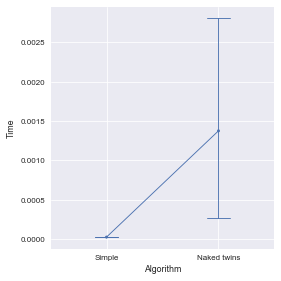

ANOVA: czynnik Success
_________________________________________________
Results: | F value : 1.1807228915662649  | p value :  0.2798743420571249
Statistics for Simple : | std. dev:  0.05714285714285715 | mean:  0.8
Statistics for Naked twins : | std. dev: 0.04642307659791976 | mean:  0.88




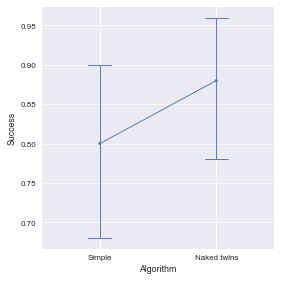

In [45]:

get_algorithms_statistics("sudoku_data\\sudoku_dataset1.txt", reduce_puzzle, reduce_puzzle_with_naked_twins)